In [27]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

from pathlib import Path
from termcolor import colored
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet50
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.metrics import AUC
from keras.utils import to_categorical
from tensorflow.keras.models import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [28]:
df_breast_cancer = pd.read_csv('/kaggle/input/rsna-dataset/train.csv')
df_breast_cancer.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [29]:
#remove outleirs of age
df_breast_cancer = df_breast_cancer.loc[(df_breast_cancer['age'] > 30) |
                                        (df_breast_cancer['age'] < 85)]

In [30]:
df_breast_cancer = df_breast_cancer.reset_index(drop=True)

In [31]:
#values for cancer before balance
df_breast_cancer.cancer.value_counts()

cancer
0    53511
1     1158
Name: count, dtype: int64

<Axes: ylabel='count'>

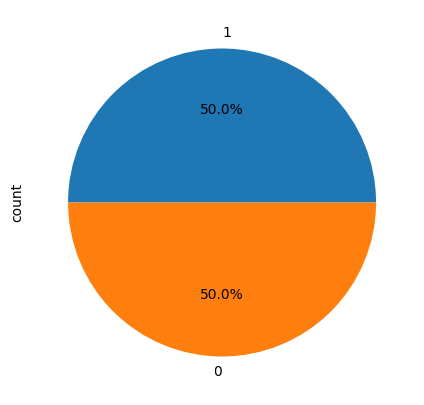

In [32]:
#balance class of cancer with not cancer aleatoring

#get number of data with class 1(cancer)
num_cancer = df_breast_cancer.cancer.value_counts()[1]

#get index on dataframe of class 1(cancer)
indexs_cancer = np.array(df_breast_cancer[df_breast_cancer.cancer == 1].index)

#get index on dataframe of class 0(not cancer)
indexs_not_cancer =np.array(df_breast_cancer[df_breast_cancer.cancer == 0].index)

#get indexs on dataframe aleatory of class 0(not cancer) with the same amount of class 1(cancer)
indexs_not_cancer_balanced = np.random.choice(indexs_not_cancer, num_cancer, replace = False)

#cancatenate indexs with data class 0 and 1
indexs_cancer_balanced = np.concatenate([indexs_cancer, indexs_not_cancer_balanced], axis = None)

#new dataframe balanced with the same amount class
df_breast_cancer = df_breast_cancer.iloc[indexs_cancer_balanced,:]

df_breast_cancer.head()
df_breast_cancer['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))

In [33]:
#values for cancer after balance
df_breast_cancer.cancer.value_counts()

cancer
1    1158
0    1158
Name: count, dtype: int64

In [34]:
# data
X = df_breast_cancer.drop('cancer', axis=1)
y = df_breast_cancer['cancer']

# Split the data into training, validation, and testing sets
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42, stratify=y_valid_test)

print(f"Training data shape: {X_train.shape}")
print(f"Number of training samples: {len(X_train)}")
print(f"Validation data shape: {X_valid.shape}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Testing data shape: {X_test.shape}")
print(f"Number of testing samples: {len(X_test)}")

Training data shape: (1968, 13)
Number of training samples: 1968
Validation data shape: (174, 13)
Number of validation samples: 174
Testing data shape: (174, 13)
Number of testing samples: 174


In [35]:
def separe_folder_train_valid_test(folders_name, files_name, name):
    for folder, file in tqdm(zip(folders_name, files_name), total=len(folders_name), desc="Saving Images"):
        img = Image.open(os.path.join(path, folder, file))
        save_path = os.path.join('/kaggle/working/rsna-mammography-images-as-pngs/', name, folder, file)
        if not os.path.exists(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        img.save(save_path)

In [36]:
#path general
path = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs/train_images_processed/'

#get train images
folders_train = X_train.patient_id.astype('str') + '/'
files_train = X_train.image_id.astype('str') + '.png'

#get valid images
folders_valid = X_valid.patient_id.astype('str') + '/'
files_valid = X_valid.image_id.astype('str') + '.png'

#get test images
folders_test = X_test.patient_id.astype('str') + '/'
files_test = X_test.image_id.astype('str') + '.png'

#separete images
separe_folder_train_valid_test(folders_train, files_train, 'train')
separe_folder_train_valid_test(folders_valid, files_valid, 'valid')
separe_folder_train_valid_test(folders_test, files_test, 'test')

Saving Images: 100%|██████████| 174/174 [00:01<00:00, 88.16it/s]


In [37]:
def get_array_imgs(folders, files):
    list_imgs = []

    for folder, file in tqdm(zip(folders, files), total=len(folders), desc='Loading images'):
        list_imgs.append(np.array(Image.open(os.path.join(path, folder, file))))

    array_imgs = np.array(list_imgs)
    # Resize the images to the correct dimensions
    array_imgs = [cv2.resize(img, (256,256)) for img in array_imgs]
    # Convert the images to RGB
    array_imgs = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in array_imgs]
    array_imgs = np.array(array_imgs)
    array_imgs = array_imgs / 255.0
    
    return array_imgs

In [38]:
array_imgs_train = get_array_imgs(folders_train, files_train)
array_imgs_valid = get_array_imgs(folders_valid, files_valid)
array_imgs_test = get_array_imgs(folders_test, files_test)

Loading images: 100%|██████████| 174/174 [00:00<00:00, 739.78it/s]


In [39]:
# Check the shape of array_imgs_train
print("Shape of array_imgs_train:", array_imgs_train.shape)

# Check the shape of array_imgs_valid
print("Shape of array_imgs_valid:", array_imgs_valid.shape)

# Check the shape of array_imgs_valid
print("Shape of array_imgs_valid:", array_imgs_test.shape)


Shape of array_imgs_train: (1968, 256, 256, 3)
Shape of array_imgs_valid: (174, 256, 256, 3)
Shape of array_imgs_valid: (174, 256, 256, 3)


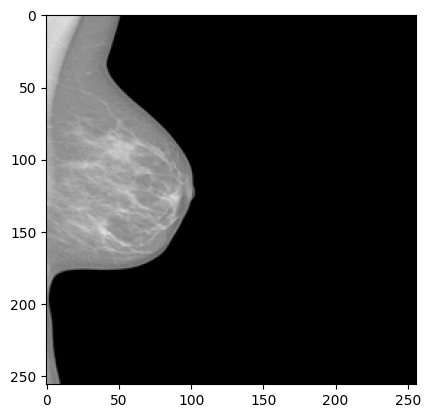

In [40]:
plt.imshow(array_imgs_train[0])

In [41]:
y_train = to_categorical(y_train, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [42]:
# Check the shape of y_train
print("Shape of y_train:", y_train.shape)

# Check the shape of y_valid
print("Shape of y_valid:", y_valid.shape)

# Check the shape of y_valid
print("Shape of y_valid:", y_test.shape)


Shape of y_train: (1968, 2)
Shape of y_valid: (174, 2)
Shape of y_valid: (174, 2)


In [43]:
y_train_binary = y_train[:, 0]
y_valid_binary = y_valid[:, 0]
y_test_binary = y_test[:, 0]

# Define your ResNet50 model
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_shape=(256, 256, 3)
)

# Define your model
model = Sequential([
    resnet,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Add a Dense layer with 2 units and sigmoid activation
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert y_train to categorical with 2 classes (assuming it's binary)
y_train_binary = to_categorical(y_train[:, 1], num_classes=2)  # Assuming the label you're interested in is in the second column

# Similarly, convert y_valid to categorical
y_valid_binary = to_categorical(y_valid[:, 1], num_classes=2)

# Fit the model with the reshaped target labels
history = model.fit(array_imgs_train, y_train_binary,
                    batch_size=32,
                    epochs=10,
                    validation_data=(array_imgs_valid, y_valid_binary))

# Display the model summary
model.summary()

# Get the output tensor of the last layer
last_layer_output = model.get_layer(index=-1).output

# Get the output shape of the last layer
last_layer_output_shape = last_layer_output.shape
print("Output Shape:", last_layer_output_shape)

Epoch 1/10


W0000 00:00:1716027086.456336      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5125 - loss: 0.6953

W0000 00:00:1716027131.839500      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 104s 780ms/step - accuracy: 0.5123 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.4902 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.5050 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.4885 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.4574 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.5130 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.4915 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.4816 - loss: 0.6932 - val_accuracy: 0.50

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,321,745 (653.54 MB)

 Trainable params: 57,089,541 (217.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 114,179,084 (435.56 MB)

Output Shape: (None, 2)


In [44]:
# Save model weights
model.save_weights("model_weights.weights.h5")

model.load_weights('/kaggle/working/model_weights.weights.h5')

In [45]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

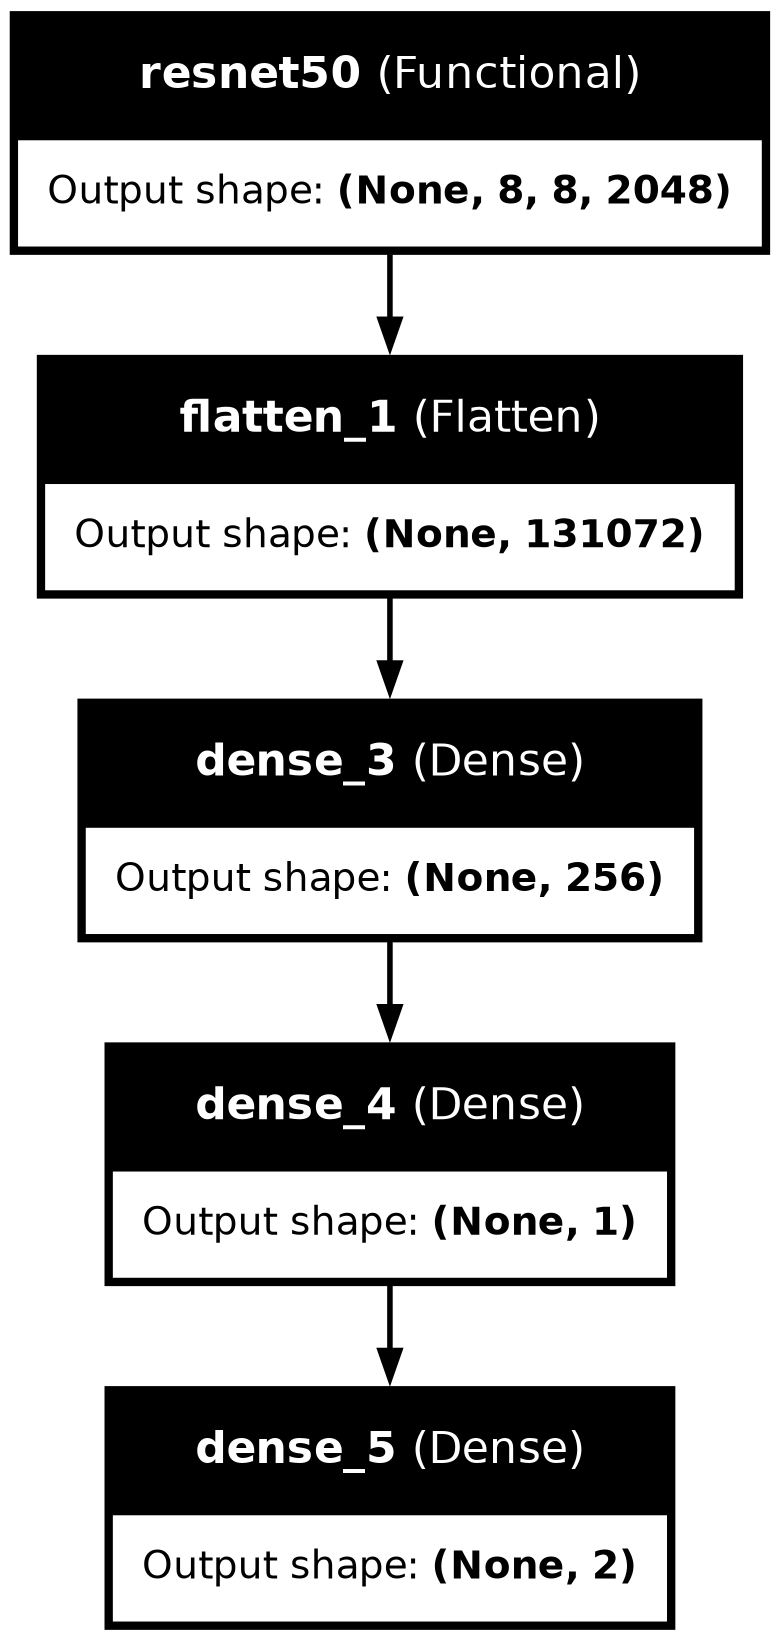

In [46]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

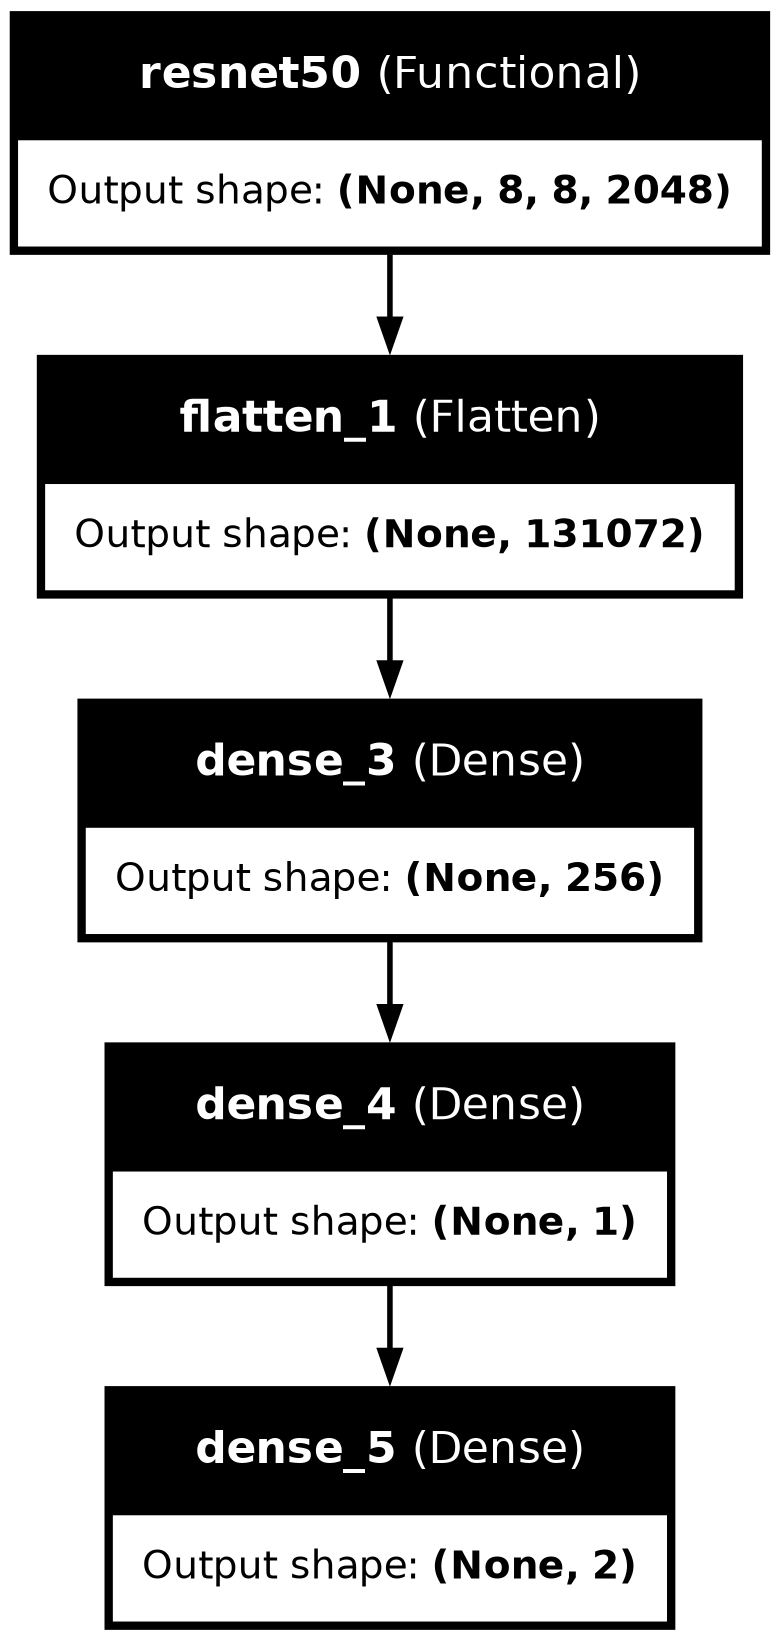

In [47]:
from IPython.display import Image
Image(filename='model_plot.png')

In [48]:
# Probabilistic F1 score metric
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [49]:
#predict images test
y_pred = model.predict(array_imgs_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 850ms/step


In [50]:
num_dimensions = y_test.ndim
print(num_dimensions)

1


In [51]:
# exploration unique values predicted and counts too
unique_values, counts = np.unique(y_pred, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [1]
Counts: [174]


In [54]:
accuracy = accuracy_score(y_test, y_pred)
print("F1 score:", f1)

F1 score: 0.6666666666666666
